# VIX Forecast-Based Volatility Trading with Asset Diversification

Sean Lin, Thomas McDonnell, Benjamin Panovich, Madison Rusch

In [2]:
import os 
import pandas as pd 
import numpy as np
import wrds 

import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import data_collection 
import model_building
import trading_strategy

import warnings 
warnings.filterwarnings('ignore')

In [3]:
KEY = os.getenv('QUANDL_KEY') # If you want to download Quandl data, put your own key here
conn = wrds.Connection(wrds_username='seanl59') # Similarly, if you want to download WRDS data, put your username here

Loading library list...
Done


***

## 1. Introduction

This notebook presents a quantitative trading strategy focused on trading volatility using VIX forecasts. Volatility is a measure of uncertainty in the markets (or variance) and VIX, CBOE's volatility index, is a popular index that measures the market's forward expectation of volatility. While high volatility can be viewed in a negative light, it can create trading opportunities. Increased volatility means increased fear in the markets, resulting in cashflow leaving equities and entering other asset classes, like fixed income, commodities, or currencies. Though equities outperform over long-periods of time, these other asset classes can outperform in moments of heightened volatility. Equity options are another asset that can be linked to volatility. In many cases, options are used to hedge our directional-risk or to even take levered directional risks, they can also be used to play volatility. Increased volatility results in higher option prices as higher volatility increases the probability that the option expires in-the-money (with value). Consequently, an option can increase in value even if the direction is wrong provided that the implied volatility is increasing quick enough. The strategy aims to capitalize on these opportunities by trading a combination of different asset classes. 

The paper is divided into three main sections. The first section focuses on predicting VIX using a time-series ARIMA(1,1,1) model. The section explores predictors and explains why they were chosen, along with an evaluation of the model's performance. The second section examines the tradeable assets that are used to implement the strategy, incorporating leverage and transaction costs; a backtest of the strategy is also presented. The third section discusses limitations of the strategy and future steps.

The objective of this notebook is to present a starting point for trading volatility. While profitability of the strategy is not the main focus, the results of the backtest show potential for quantitative strategies in this realm and serves as a starting point for future research into more profitable volatility-related trading strategies.

***

## 2. Building the Model

This section presents the ARIMA(1,1,1) model used for forecasting VIX. The inspiration for this model comes from Ahoniemi's 2006 paper, which demonstrated that ARIMA(1,1,1) models were the best linear models for forecasting VIX. A similar model is presented in this notebook, which uses SPY returns, MSCI EAFE (ex-US developed market) returns, SPY volume change, and economic calendar events as regressors.

The rationale for these regressors is as follows:
- SPY returns typically have large negative correlation with VIX returns. When SPY has a large negative day, it is likely that VIX is positive.
- MSCI EAFE returns do not include US markets and may have lower correlation. However, they provide information from other parts of the world, which can add to the model.
- Days with large SPY volume can be significant. This can indicate that investors are leaving equities. For example, during the Russian invasion of Ukraine, there was an extremely high amount of volume.
- Days with economic calendar events can be more volatile. These events can include FOMC or CPI events. For example, as of lately, CPI events can cause SPX to have 100 point moves in minutes. This phenomenon can also be seen with non-economic calendar events, like earnings. A common strategy is to buy option straddles for a company releasing earnings (i.e NFLX and META during certain 2022 earnings reports).

In this model, a rolling-window of 126 days is used to forecast the next-day-out. Afterward, the rolling window is shifted to include the most recent day and the process is repeated. To remove forward-looking bias, SPY volume and SPY/EAFE returns are lagged. This is a noteable difference from Ahoniemi's paper, where EAFE returns are contemporaneous with SPX returns as they trade at the trading day open and predict the end-of-day return. Here, the next day's VIX returns are predicted. This is due to the unavailability of bid and offers of options at the open.

Here, the class `DataCollection` is used to obtain data for various equities and future contracts using the *Quandl* database. In addition, certain data is download from other websites (i.e investing.com and marketwatch.com). This includes VIX data or economic calendar data. Raw data is also presented in the */data/* folder (i.e economic calendar, EAFE, VIX).

In [3]:
START_DATE, END_DATE = '2014-01-01', '2021-12-31' 
YEARS = ['2014','2015','2016','2017','2018','2019','2020','2021','2022']
MONTH_CODES = ['H','M','U','Z']
DataCollection = data_collection.DataCollection(KEY,START_DATE,END_DATE,YEARS,MONTH_CODES) # Class used for data collection

In [4]:
vix_data = pd.read_csv('./data/vix_data.csv',index_col=0,parse_dates=True) # VIX data, obtained from investing.com
raw_calendar_data = pd.read_csv('./data/calendar_raw.csv',index_col=0,parse_dates=True) # Raw economic calendar data, obtained from marketwatch.com
eafe_data = pd.read_csv('./data/eafe_data.csv',index_col=0,parse_dates=True) # EAFE data, obtained from investing.com
spy_data = DataCollection.fetch_quandl_table('QUOTEMEDIA/PRICES','SPY')

calendar_data = DataCollection.convert_calendar(raw_calendar_data,vix_data) # Converting raw calendar data to processed data 
predictors = pd.concat([vix_data,eafe_data,spy_data,calendar_data],axis=1)

predictors['VIX Returns'] = predictors['VIX'].pct_change().shift(-1) # Shifting the data
predictors['SPY Returns'] = predictors['close'].pct_change() 
predictors['EAFE Returns'] = predictors['EAFE'].pct_change()
predictors['Days until Event'] = predictors['Days until Event'].shift(-1)
predictors['Volume Change'] = predictors['volume'].pct_change()
predictors = predictors[['VIX Returns','SPY Returns','EAFE Returns','Days until Event','Volume Change']].dropna()

The `model_building` class is used to construct the ARIMA(1,1,1) model using a rolling-window size of 126 (correpsonding to 1/2 a year in trading days) to forecast future values of VIX returns.

An ARIMA model, or an auto-regressive integrated moving average model is a time-series model used to forecast future values of a variable (in this case, VIX returns) based on past values. It is composed of three components: p, d, and q, which correspond to the autoregressive, integrated, and moving average components respectively.

The autoregressive component (p) models the linear relationship between VIX returns and its past values assuming that the current value is a linear combination of the previous values. The parameter p indicates the number of lagged values that are used to forecast the future value.

The integrated component (d) accounts for any non-stationarity present in the data. It differences the time-series with a lag of d in order to make it stationary. 

The moving average component (q) models the noise (or error terms) in the data as a linear combination of previous values. In other words, it is the number of lagged values of the error term to predict future values. 

In this notebook, a (1,1,1) ARIMA model is used.

In [5]:
Model = model_building.Model(predictors,126)
Model.train_model()

100%|██████████| 1887/1887 [02:30<00:00, 12.51it/s]


When evaluating these models, it's important to look at the p-values of the regressor coefficients. A low p-value (usually < 0.05) indicates that the coefficients are significant and meaningful. A high p-value (> 0.05) means that the coefficients may not be significant. Here, we can see that there are periods where the coefficients are significant and periods where the coefficients are not significant. This means that results from these periods should be viewed with caution. It is important to remember that the p-value is not the probability of the coefficient being significant. The p-value is a result of standardizing the T-statistics when forming the hypothesis tests and corresponding confidence intervals.

In [6]:
Model.plot_pvalues()

Some observations:
- We see that the MA component is almost always significant compared to the other predictors. It is not as significant towards the end of the sample.
- The AR component appears to be the most significant towards the end of 2015. 
- The EAFE returns appears to be the least significant out of all the predictors. It doesn't have a whole period where it's significant like the other predictors.

Let's quantify this a bit more: let's look at the proportions of time in which each predictor is significant.

In [7]:
Model.calc_significance().T

,SPY Returns,EAFE Returns,Days until Event,Volume Change,AR,MA
Proportion,0.109698,0.067303,0.107578,0.059353,0.125596,0.837838


We can see that the MA component has the highest proportion of being significant, followed by the AR component, and then economic calendar. This is in line with what we qualitatively observed.

Now, let's look at the betas. We will *ignore* the fact that some of the betas aren't always significant. It should be remembered that this is a valid (and very important!) concern. For the highest statistical confidence, the coefficients should be significant: this will be touched on later. When looking at the betas, we are primarily looking at the signs. The betas can give an expected change in VIX returns with a change in a certain predictor. For example, in univariate linear regression, if we are regressing *price of house* on *square feet* and we obtain the following equation $ \text{Price of House} = 500 (\text{Square Feet}) + 2 $ (a potentially unrealistic equation), this would mean that for every 1 increase in square feet, we would expect the price of the house to increase by $500.

In [8]:
Model.plot_betas()

We see that the betas are always negative for the MA component while they tend to vary for the other components. From these results, we can see why it is important for significant coefficients. These confidence intervals could include 0, meaning that the coefficient is 0 and actually has no effect on the VIX returns. This is why we will ignore this and continue with the analysis. We do note that the betas for the EAFE returns have a significant proportion of time being negative. A negative beta means that VIX returns will increase when the predictor decreases. This is in-line with what was observed in Ahoniemi (2006), Flemings et. al (1995) and Simons (2003). This is reasoned by the fact that "a negative coefficient leads to a drop in VIX if the returns in foreign markets have been positive and vice versa for negative returns". On the contrary, we see mostly positive betas for SPY (which is also seen in the paper). This can be attributed to positive SPY returns causing VIX to fall during day T, so in day T+1, VIX will raise as it is mean reverting.

Let's show that VIX is mean-reverting with the Augmented Dickey-Fuller test. We will first provide a visual.

In [9]:
fig = make_subplots(rows=1,cols=1,subplot_titles=("VIX",))
fig.add_trace(go.Scatter(x=vix_data.index,name="VIX",y=vix_data['VIX']),row=1,col=1)
fig.update_xaxes(title='Date')
fig.update_yaxes(title='Price')
fig.update_layout(margin=dict(t=25, l=25, b=25))

In [10]:
print('AdFuller p-value: ' + str(np.round(adfuller(vix_data)[1],5)))

AdFuller p-value: 5e-05


From the ADF test, we can see that the p-value is very small, indicaing that VIX is mean-reverting. It is also good to note that this is the entire-sample (and we are trading on this). However, this does not affect any of our decisions. Now, let's look at some performance metrics for the ARIMA(1,1,1) model.

There will be two main metrics: mean-squared error (MSE) and directional accuracy. We define MSE to as the squared difference between the prediction and the true result. Directional accuracy is the percentage of time where the prediction and the true value have the same sign. The same sign is important as it indicates whether the model is predicting the direction of VIX correctly. We also include two other metrics derived from the directional accuracy: up and down accuracy. These are the accuracies conditional on the prediction being above a certain threshold. We also note the number of predictions, or the number of trades that can be realized throughout this period.

It is important to understand how up and down accuracy are calculated. These are the accuracies conditional on the predicted value being above some threshold. To be precise, these thresholds are generated from a rolling-quantile of true values. In other words, a rolling 75th and 25th quantile are calculated from the last 125 trading days. This is then marked as the threshold for significant "VIX increase" predictions and significant "VIX decrease predictions" respectively. Here, we choose the rolling quantiles to be 0.75 and 0.25 arbitrarily. However, these values can be chosen to be anything in between 0 and 1. For simplicity, we use the 125 days such that we start our sample in 2015. We could use the true values from the first half of 2014 but this ensures that we have uniform yearly results.

It is also important to note that this mechanism may not work for other ARIMA models with different parameters. For example, a (0,0,1) model will have predictions values that are quite small and may not ever reach the true value. In that case, it may be better to utilize the rolling quantiles of the predicted values. The (1,1,1) model does not have this issue and thus we use the true values as the basis for the rolling quantile.

In [11]:
Model.performance_metrics(0.75,0.25)
Model.metrics

,MSE,DA,Up Acc,Down Acc,Prediction Num
Metrics,0.009251,0.479067,0.520408,0.625,130


We can see that the directional accuracy is less than 50%, meaning that we are correct on the directional accuracy less than half the time. This may seem discouraging. However, we note that the up-accuracy and down-accuracy are greater than 50% when we only consider predictions above and below a certain threshold. This is commonly done for these types of models as it helps filter out the noise, especially in environments where the signal-to-noise ratio is so low. 

Let's make the idea of the thresholds more precise. We will plot the predictions and true values of VIX along with the rolling thresholds for the first half of 2020. The rolling thresholds are shifted using the previous 125 days to prevent any forward-looking bias (though even if it was present, it wouldn't cause a significant change).

In [12]:
Model.plot_predictions('2020-01-01','2020-06-01')

From this sample, we see the true value of VIX in red and the predicted value in blue. We see that we enter a trade everytime the predicted value goes above the upper threshold or below the lower threshold. The idea of trading based on the ARIMA model will be made precise in the next section.

***

## 3. Trading Strategy

Now that the model has been solidified, we can now move onto forming the trading strategy associated with the VIX forecasting model. As mentioned earlier, there are several different assets one can consider when thinking about volatility: commodities, fixed income, currencies, and options. Here, we will focus on commodities, fixed income, and options. Before we delve into these assets, let's discuss the trading strategy.

As shown in the previous section, the ARIMA model gives one-day-out forecasted VIX returns. We also saw that on it's own, the directional accuracy was less than 50%. However, if we restricted the thresholds at which it activates, the accuracy increases. Using a 75% and 25% rolling quantile of actual values, the up-accuracy is around 52% while the down-accuracy is 62.5%, totaling 130 trades over 6 years. This gives us the capability of betting on volatility to increase as well as betting on volatility to decrease. In other words, we can buy assets with positive correlations and short assets with negative correlations to VIX when the model predicts high returns and then vice versa when the model predicts decreasing volatility. This will be the approach that we use: we will find assets that are correlated to VIX and trade a portfolio of them. Since the ARIMA only predicts one-day-out, we will only hold our positions for one day at a time. This allows us to actually capitalize on the model. It wouldn't make sense to predict one-day-out forecasts and hold for more than one day. 

There would be a tremendous amount of lookahead bias if we looked at the entire sample for correlations and then determined assets based on that. Instead, we will only look at 2014 (as we are not trading during this period) to determine the assets (or portfolio) we will use from 2015-2021. In real scenarios, with trading *portfolios*, it may be better to update assets over time as certain assets may become more or less correlated.

First, let's look at future contracts. We'll first make a new DataCollection object with only the year 2014.

In [13]:
START_DATE, END_DATE = '2014-01-01', '2014-12-31' 
YEARS = ['2014','2015']
MONTH_CODES = ['H','M','U','Z']
DataCollection2014 = data_collection.DataCollection(KEY,START_DATE,END_DATE,YEARS,MONTH_CODES) 

For futures, we will look at the following futures: GC, SI, NG, RB, LC, W, CL, C. For the most part, these were arbitrarily chosen. However, from *Jubinski, Lipton 2013*, it's seen that silver, gold, and oil all react in some manner to volatility. These will be the main focus of this correlation analysis.

In [14]:
gc_data = DataCollection2014.get_contract('CMX_GC_GC')
si_data = DataCollection2014.get_contract('CMX_SI_SI')
ng_data = DataCollection2014.get_contract('NYM_NG_NG')
rb_data = DataCollection2014.get_contract('NYM_RB_RB')
lc_data = DataCollection2014.get_contract('CME_LC_LC')
w_data = DataCollection2014.get_contract('CBT_W_W')
cl_data = DataCollection2014.get_contract('NYM_CL_CL')
c_data = DataCollection2014.get_contract('CBT_C_C')

In [15]:
futures = pd.concat([gc_data,si_data,ng_data,rb_data,lc_data,w_data,cl_data,c_data],axis=1)
futures.columns = ['GC','SI','NG','RB','LC','W','CL','C']
futures = futures.loc[futures.index.isin(vix_data.loc[START_DATE:END_DATE].index)]
futures = futures.pct_change().dropna()

In [16]:
correlations_to_vix = pd.DataFrame(columns=['Unconditional Correlation to VIX','Conditional Correlation to VIX'])
for column in futures.columns.values:
    vix_returns = vix_data.loc[START_DATE:END_DATE].pct_change().dropna()['VIX']
    correlations_to_vix.loc[column,'Unconditional Correlation to VIX'] = (futures[column]).corr(vix_returns)
    correlations_to_vix.loc[column,'Conditional Correlation to VIX'] = (futures[column]).corr(vix_returns[(vix_returns > 0.07) | (vix_returns < -0.07)])
display(correlations_to_vix.T)

,GC,SI,NG,RB,LC,W,CL,C
Unconditional Correlation to VIX,0.162451,0.009887,0.075714,-0.17276,-0.007917,0.015744,-0.121513,-0.109888
Conditional Correlation to VIX,0.288983,0.028733,0.058526,-0.228743,-0.053311,-0.000149,-0.166474,-0.236865


We divide the correlations into unconditional and conditional correlations. The unconditional correlations are on the entire sample of 2014. The conditional correlation only includes samples where VIX returns above 7% or below -7%. The threshold of 7% and -7% was chosen arbitrarily as some non-zero threshold where more careful comparisons can be made. We can see that in many cases, the conditional correlation is higher. This can be seen for GC, RB, CL, and C. Jubinski and Lipton's paper also showed that silver also responds to volatility, though it is not seen in our 2014 sample. Let's now look at the correlations between the assets. 

<AxesSubplot: >

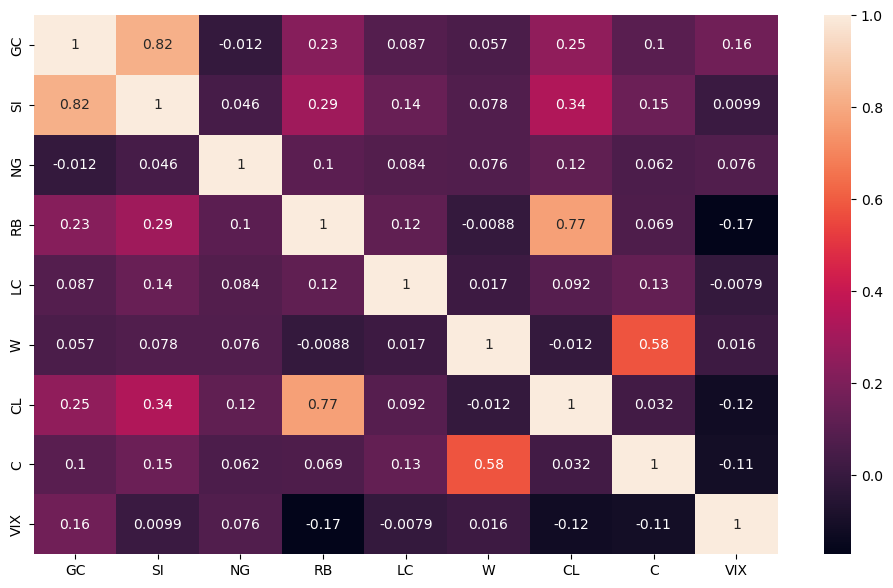

In [17]:
all_futures = pd.concat([futures,vix_data.loc[START_DATE:END_DATE].pct_change().dropna()],axis=1)
plt.subplots(figsize=(12,7))
sns.heatmap(all_futures.corr(),annot=True)

For the trading strategy, we elect to use CL and SI. These choices were made in unison with the results from the paper as well as the correlations seen in 2014. From the paper, it is evident that CL and SI are both correlated to volatility in the markets. We saw that CL has a high magnitude in unconditional correlation to VIX returns. Our choice is in SI is done with primarily evidence from the paper and done to hopefully prevent overfitting. We see that GC and SI are highly correlated but SI has a low correlation to VIX compared to GC. The choice in SI can also prevent any overfitting that could be done with the small sample of 2014.

We will now look at the correlations of bonds with VIX.

In [18]:
bond20y_data = DataCollection2014.fetch_quandl('YC/USA20Y')
bond10y_data = DataCollection2014.fetch_quandl('YC/USA10Y')
bond5y_data = DataCollection2014.fetch_quandl('YC/USA5Y')
bond1y_data = DataCollection2014.fetch_quandl('YC/USA1Y')

<AxesSubplot: >

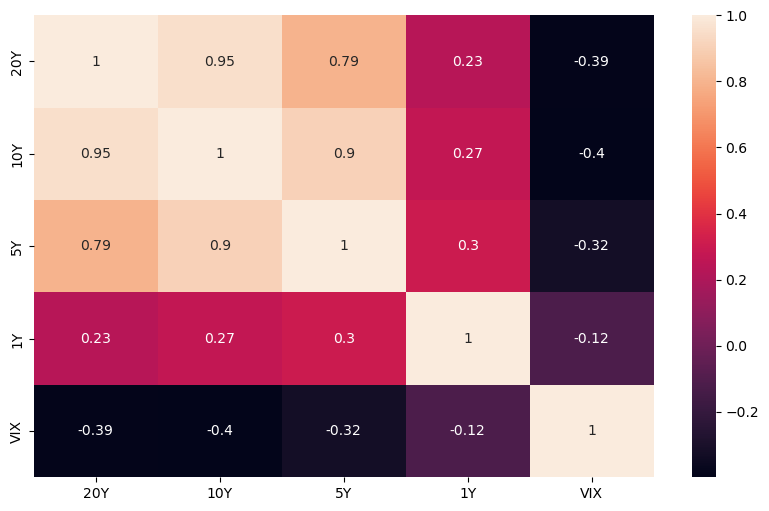

In [19]:
bond_data = pd.concat([bond20y_data,bond10y_data,bond5y_data,bond1y_data],axis=1)
bond_data.columns = ['20Y','10Y','5Y','1Y']
bond_data = bond_data.loc[bond_data.index.isin(vix_data.loc[START_DATE:END_DATE].index)]
bond_data = bond_data.pct_change().dropna()
bond_data = pd.concat([bond_data,vix_data.loc[START_DATE:END_DATE].pct_change().dropna()],axis=1)

plt.subplots(figsize=(10,6))
sns.heatmap(bond_data.corr(),annot=True)

We see that the correlation between bond yields and VIX is generally negative, with the correlation increasing as the duration increases. Thus, when we expect high VIX returns, we would expect rising bond prices as yield is inversely correlated to bond prices. As a substitute to calculating bond prices, we will use a bond ETF. Here, we select TLT.

To summarize, we will use 5 different assets for our trading strategy: TLT (bond ETF), CL (crude oil future), SI (silver future). The last 2 assets will be with SPY ETF and the correspond vanilla SPY option. As mentioned earlier, SPY options can increase in value if the implied volatility (or vega) increases. By buying vanilla SPY calls and shorting SPY ETF to remain delta neutral, we can be inpervious to the directional changes in the market and be primarily exposed to vega (though there is some gamma risk).

The options data was retrieved from WRDS. Due to the file size, the entire chain is not provided (though a small subset for a day is provided, named *options_chain_sample*). To access the entirety, you will need to first generate signals with the `TradingStrategy` class before using the *obtain_chain()* function. 

In [20]:
options_chain = pd.read_csv('options_chain.csv',index_col=0,parse_dates=True)
TradingStrategy = trading_strategy.TradingStrategy(Model.predicted_results,0,spy_data,vix_data,conn,options_chain)
TradingStrategy.create_signals()
TradingStrategy.signals.to_csv('signals.csv')

In [21]:
tlt_data = pd.read_csv('./data/tlt_data.csv',index_col=0,parse_dates=True)
cl_data = pd.read_csv('./data/cl_data.csv',index_col=0,parse_dates=True)
si_data = pd.read_csv('./data/si_data.csv',index_col=0,parse_dates=True)

With the assets being established, it is now a good time to discuss position sizing. The portfolio consist of 5 assets, though 1 asset directly depends on another (the number of SPY directly depends on the total delta of the call options). However, the 3-other assets are independent of each other and we will give them equal *maximum allocation*. In other words, the maximum capital that we can allocate to each asset is the same. We will choose \$100000 for simplicity. This means that the maximum capital size for each asset is \$100000. This does not mean that the allocation is always \$100000. For the futures (SI and CL) and the bond ETF (TLT), we are betting on the direction of these assets as a proxy to VIX. Since these assets are correlated to VIX, it would make sense to set our position size based on a measure of correlation. If the asset has a greater correlation coefficient (in magnitude), we would want to have a larger position. As a result, we choose to take a rolling 30-day historical correlation of the asset returns and VIX and set our position size to be equal to $\text{corr(VIX, asset) * capital}$. For the option component, we will always use the entire capital amount as this component is always hedged against directional market movements. It is fine to be fully allocated as the only risk is volatility risk (and small gamma risk). Here, we will set the initial capital to be \$10000. This is much lower as options can have large percentage increases with small movements in the underlying. For example, the delta of the options we are buying are around 0.5. If the stock increases by $1, then the option will increase by 50 cents. In many cases, the ATM strike has a price of around $4. Here, 50 cents is a 12.5% increase in value. Thus, we do not need a large capital base for options. 

It is also important to mention the leverage requirements. Futures are a leveraged product and require some margin that needs to be met (known as the maintenance margin). Here we, will consider *our margin* to be two times the maintenance margin. This assumption should prevent us from being forced to exit our positions (getting margin called). This, along with the fact that correlations will never be more than 0.5 between the asset and VIX should ensure proper risk measures. An argument can potentially be made that SPY has a correlation of -0.70. However, SPY ETF and SPY option ETFs position sizing are not calculated with the correlation, but rather the entire portfolio. 

For the bond ETF, we assume a maximum of a 2x leverage ratio. In simpler terms, if we buy 200 shares of TLT, we can borrow another 200 shares. We use the correlation position sizing specified below, multiplied by 3. Since this value is usually less than 0.5, this will bring us to a 1.5x our capital, or a leverage ratio of 1.5x. Since the correlations will never be *too big*, we will assume that the margin we have used is enough to fund our account and avoid margin calls. Furthermore, we assume that our short positions can be properly funded by the rest of our long positions. For example, if we predict volatility to increase, we will have collateral in bond ETF, call options, and certain futures. This will give us enough collateral to open our SPY short position. The converse can be said when we predict volatility to decrease and thus are short bond ETF. 

In terms of entry and exit, we will enter when the prediction is above or below a threshold. If the prediction is above the rolling threshold (mentioned earlier), a long position will be entered. The long position consists of shorting CL, buying SI, buying TLT, buying SPY calls, and shorting SPY ETF. If the prediction is below the rolling threshold, the opposite position is taken. The exit will always be one day later as the forecast is a one-day forecast. There is no reason to remain in the position for a longer time and as a result, there is no formal stop loss -- the one-day time interval serves as the stop loss. The short trade time should help remedy the high tail risk that is present in these types of strategies, especially when trying to short VIX. VIX is naturally decaying, but can spontaneously shoot up unexpectedly and result in huge losses. 

We also make the assumption that everything can be bought at the close. Since the maximum position size is \$100,000, we can assume there is enough liquidity at close. In addition, the \$100,000 is the maximum amount that can be used. In many cases, the actual amount will only be 20 or 30% this size. When considering options liquidity, we will only consider the options that are at-the-money and have the second nearest expiration-date. These options are the most liquid and should help make our assumptions valid. 

This will result in an overall capital base of $100000 for the futures ($200000 total), $100000 for the long equities, and then $10000 for the options. To be safe, we will round this up to $350,000 and set this as our initial capital. We will now walk through the trading strategy by first considering 0 transaction fees.

In [22]:
positions_si = TradingStrategy.position_sizing(si_data,30)
si = TradingStrategy.backtest(si_data,-1,positions_si,100_000,16000,5000,mode='future')[['Daily PnL']]
positions_cl = TradingStrategy.position_sizing(cl_data,30)
cl = TradingStrategy.backtest(cl_data,-1,positions_cl,100_000,12000,1000,mode='future')[['Daily PnL']]
positions_tlt = TradingStrategy.position_sizing(tlt_data,30)
tlt = TradingStrategy.backtest(tlt_data,1,positions_tlt,100_000,None,mode='equity')[['Daily PnL']]

Futures have quarterly expires and thus it is good to roll them over at an earlier point to avoid liquidity issues when exiting positions near expirations. To roll the futures contracts, we will collect pricing data on futures contracts expiring in March, June, September, or December. We will then keep only the contracts with at least 30 days left to expiration to ensure none of the contracts we hold will expire suddenly on a day we are holding contracts. This fact will help in our liquidity assumptions.

The leverage of futures is also done through its multiplier. Silver futures have a multiplier of 5000, meaning that for every $1 move in SI futures, your PnL will move $5000. Similarly, the multiplier for crude oil is 1000. We set the margin requirement of SI to be 16000 (approx. 2x of its historical max) and the margin requirement of CL to be 12000 (also approx. 2x of its historical max). This ensures that we will not get margin called and utilize the remaining capital as collateral for our other assets.

In [23]:
options = TradingStrategy.backtest_options(10_000)
positions_opt = options['Delta'].to_frame('Size')
spy = TradingStrategy.backtest(spy_data[['close']],-1,positions_opt,100_000,None,mode='spy')[['Daily PnL']]

Note that in the above backtesting of the SPY ETF and option calls that we use the closing price of SPY rather than the adjusted closing price. This is due to option calls being based on the actual closing prices of SPY, rather than the adjusted, which may take into account any historical price adjustments such as dividend payouts. We use closing prices of TLT to maintain consistency between the equity asset class.

In [24]:
daily_pnls = pd.concat([si,cl,tlt,options['Daily PnL'],spy],axis=1)
daily_pnls.columns = ['SI','CL','TLT','SPY Calls','SPY ETF']

At this point, we have conducted the initial backtests for the different assets. Let's now plot them. The SPY ETF and SPY Call positions directly correspond to each other due to the delta-hedged nature and we will first show them together.

In [25]:
delta_hedge_pnl = daily_pnls[['SPY Calls','SPY ETF']]
delta_hedge_pnl['Total'] = delta_hedge_pnl['SPY Calls'] + delta_hedge_pnl['SPY ETF']

In [26]:
TradingStrategy.plot_pnls(delta_hedge_pnl,0,'2015','2021',title='Delta Hedged Position',yaxis='PnL',adj_h=500,adj_w=900)

We see that the PnL of the SPY calls and the PnL of the SPY ETF appear to mirror each other. This is in-line with what we would expect as these assets are delta-hedged with each other and profits should arise primarily from changes in vega (or potentially gamma). It can be seen that at the end of the period, we make around $500. 

We will now plot the rest of the assets on one graph (once again, considering 0 transaction fees).

In [56]:
TradingStrategy.plot_pnls(daily_pnls.iloc[:,:5],0,'2015','2021',yaxis='PnL',adj_h=500,adj_w=900)

Some observations:
- CL has the biggest run up during COVID
- None of the assets appear to do particularly well during the first 4 years, but seem to do quite well during the first quarter of 2020. This makes sense as COVID was a time with the greatest amount of volatility.
- We see that the PnLs are relatively flat after COVID, besides SI which seems to have some volatility.

Let's quantitatively assess these performance of each asset. We assume a \$100,000 base capital for each asset to make these comparisons (though this isn't exactly true for the SPY calls). 

In [60]:
TradingStrategy.performance_metrics((100_000+daily_pnls.iloc[:,:5].cumsum()).pct_change().dropna())

,SI,CL,TLT,SPY Calls,SPY ETF
Annualized Return,0.045183,0.036275,0.037156,-0.090826,0.101939
Annualized Volatility,0.099682,0.190319,0.073267,0.295512,0.258306
Annualized Sharpe Ratio,0.453276,0.190599,0.507135,-0.307352,0.394646
Annualized Sortino Ratio,0.173653,0.066427,0.186053,-0.13937,0.169062
Skewness,8.527124,2.8534,7.413519,3.092603,4.246691
Kurtosis,181.205697,163.479079,233.492349,92.835178,107.399483
VaR (0.05),0.0,0.0,0.0,0.0,0.0
CVaR (0.05),-0.000328,-0.000872,-0.00022,-0.001913,-0.001266


Let's combine all the assets with an initial capital of $400,000 (assuming that the capital from the futures, long equities, and SPY options covers the short positions).

In [29]:
daily_pnls['Portfolio'] = daily_pnls.sum(axis=1)
portfolio_pnl = daily_pnls[['Portfolio']]
TradingStrategy.plot_pnls(portfolio_pnl,350000,'2015','2021',title='Combined Portfolio Returns',adj_h=500,adj_w=900)

In [30]:
TradingStrategy.performance_metrics((350000+portfolio_pnl.cumsum()).pct_change().dropna()).T

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Skewness,Kurtosis,VaR (0.05),CVaR (0.05)
Portfolio,0.032792,0.087677,0.374011,0.143934,3.70355,120.886505,0.0,-0.000388


We see that the Annualized Sharpe Ratio is about 0.43 with an annualized return of 0.026. It is likely that this annualized return comes from 2020, where our portfolio grows about 20%. This is also evident in the positive skewness and extremely high kurtosis.

***

## 4 Performance Analysis

Now that we have conducted the initial backtests on the trading strategy, we can begin to dig deeper into trading strategy. We will begin by considering transaction fees.

There are different transaction fees dependent on asset class and brokerage. There are also costs to consider when shorting assets. This strategy utilizes futures, ETFs and options, and to remain as consistant as possible, trading fees are taken from Charle's Schwab when available. 

For futures, trading fees are quite simple. There is a 2.25$ fee per futures contract traded. If a one futures contract is bought and then sold then a charge of 4.50$ will be taken out of profit, 2.25$ from the buy and 2.25$ from the sell. The other main issue with futures is the maintenance requirement. For Silver, the maintenance requirement for one short term contract currently is 8,500$ and for Crude oil it is 
6,600$. This means that at all times, the trader must have more than the maintenance requirement in their account. As mentioned above, we chose a conservative estimate of two times the current maintenance requirement as it is subject to change depending on market conditions.

For the TLT ETF, trading fees are free on charles Schwab. To be conservative, a .1% trading fee was assumed for every dollar amount traded, along with the management fee. On Ishares (Blackrock) who offers TLT there is a .15% management fee, but this is yearly so to account for this it is divided by 252 for each trade. Our final transaction costs for TLT will be .1% + .15%/252 for each dollar traded.

For options contracts traded on Charles Schwab, one must pay a fee of 65 cents per contract (100 contracts by convention in American equities). This makes keeping up with fees simple for options as the fees are simply .65 for every contract traded each day.

For SPY, the trading fees are similar to TLT in that a conservative .1% trading fee was assumed along with the management fee, which for SPY is .09% yearly. This results in overall fees for SPY being .1% + .09%/252 per dollar traded.

For TLT and SPY, shorting costs must also be considered. Shorting costs are generally higher than these transaction fees, and subject to change. After extensive research, a paper (cited at the bottom) identifies the median shorting fee for ETF's to be .3%. In this trading strategy, everytime TLT or SPY is shorted there is a .3% fee taken out of the PnL for this shorting cost.

In [31]:
si_fee = TradingStrategy.backtest(si_data,-1,positions_si,100_000,16000,5000,mode='future',transaction_fee=2.25)[['Daily PnL']]
cl_fee = TradingStrategy.backtest(cl_data,-1,positions_cl,100_000,12000,1000,mode='future',transaction_fee=2.25)[['Daily PnL']]
tlt_fee = TradingStrategy.backtest(tlt_data,1,positions_tlt,100_000,None,mode='equity',transaction_fee=.0001+.15/252,shorting_fee=0.003)[['Daily PnL']]
options_fee = TradingStrategy.backtest_options(10_000,fee=0.65)
spy_positions = options_fee['Delta'].to_frame('Size')
spy_fee = TradingStrategy.backtest(spy_data[['close']],-1,spy_positions,100_000,None,mode='spy',transaction_fee=.0001+.09/252,shorting_fee=0.003)[['Daily PnL']]

In [44]:
daily_pnls_fee = pd.concat([si_fee,cl_fee,tlt_fee,options_fee['Daily PnL'],spy_fee],axis=1)
daily_pnls_fee.columns = ['SI','CL','TLT','SPY Calls','SPY ETF']
delta_hedge_pnl_fee = daily_pnls_fee[['SPY Calls','SPY ETF']]
delta_hedge_pnl_fee['Total'] = delta_hedge_pnl_fee['SPY Calls'] + delta_hedge_pnl_fee['SPY ETF']

In [45]:
TradingStrategy.plot_pnls(delta_hedge_pnl_fee,0,'2015','2021',title='Delta Hedged Position (with fees)',yaxis='PnL',adj_h=500,adj_w=900)

We see that by including transaction fees, we no longer make money on the delta-hedged position, though the SPY calls and SPY ETF appear to move inversely to each other. It is likely that the value of the option does not appreciate enough in a day when considering the transaction fees. We now show a plot with the various components of the portfolio plotted.

In [57]:
TradingStrategy.plot_pnls(daily_pnls_fee.iloc[:,:5],0,'2015','2021',title='Total Returns (with fees)',yaxis='PnL',adj_h=500,adj_w=900)

In [59]:
TradingStrategy.performance_metrics((100_000+daily_pnls_fee.iloc[:,:5].cumsum()).pct_change().dropna())

,SI,CL,TLT,SPY Calls,SPY ETF
Annualized Return,0.044948,0.035585,0.0296,-0.096804,0.095386
Annualized Volatility,0.099833,0.190902,0.076318,0.309706,0.343006
Annualized Sharpe Ratio,0.450237,0.186406,0.387847,-0.312567,0.278089
Annualized Sortino Ratio,0.239491,0.090191,0.221963,-0.161189,0.158472
Skewness,8.532713,2.873571,7.441365,3.274956,5.235507
Kurtosis,181.311982,163.636189,237.165988,96.543519,130.876583
VaR (0.05),-0.000022,-0.000062,-0.00058,-0.000367,-0.003359
CVaR (0.05),-0.006372,-0.016916,-0.004852,-0.038434,-0.032763


We see that the performance of each asset has decreased. The greatest decrease is seen in the SPY and TLT. This is likely due to the large shorting fees present in ETFs. In futures, shorting is the same as going long and the difference is very marginal.

In [48]:
daily_pnls_fee['Portfolio'] = daily_pnls_fee.sum(axis=1)
portfolio_pnl_fee = daily_pnls_fee[['Portfolio']]
TradingStrategy.plot_pnls(portfolio_pnl_fee,350000,'2015','2021',title='Combined Portfolio Returns (with fees)',adj_h=500,adj_w=900)

In [37]:
TradingStrategy.performance_metrics((350000+portfolio_pnl_fee.cumsum()).pct_change().dropna()).T

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Skewness,Kurtosis,VaR (0.05),CVaR (0.05)
Portfolio,0.018751,0.094135,0.199193,0.109281,4.11695,128.126089,-0.001166,-0.008606


We see that the Sharpe Ratio has decreased by a factor of 2 after including transaction costs. 

Since our trading strategy involves trading a portfolio of assets, we will primarily utilize the portfolio for the rest of our analysis. Let's do a year-by-year comparison. We will utilize Sharpe Ratio as our main metric.

In [38]:
no_fee_sharpes = TradingStrategy.year_analysis(portfolio_pnl,350_000,[2015,2016,2017,2018,2019,2020,2021]).loc[['Annualized Sharpe Ratio']]
fee_sharpes = TradingStrategy.year_analysis(portfolio_pnl_fee,350_000,[2015,2016,2017,2018,2019,2020,2021]).loc[['Annualized Sharpe Ratio']]
sharpes_comparison = pd.concat([no_fee_sharpes, fee_sharpes])
sharpes_comparison.index = ['Sharpe Ratio (No Fees)','Sharpe Ratio (Fees)']

TradingStrategy.year_analysis(portfolio_pnl,350_000,[2015,2016,2017,2018,2019,2020,2021])

,2015,2016,2017,2018,2019,2020,2021
Annualized Return,0.015146,-0.006492,-0.054088,-0.01096,0.145549,0.133134,0.008014
Annualized Volatility,0.065181,0.034732,0.057859,0.070018,0.131422,0.134101,0.068305
Annualized Sharpe Ratio,0.232362,-0.186929,-0.934827,-0.156526,1.107499,0.99279,0.117322
Annualized Sortino Ratio,0.045191,-0.079894,-0.329799,-0.069262,0.585624,0.47128,0.030438
Skewness,-4.761308,2.85464,-4.782413,-0.185119,4.047094,3.894739,-3.457496
Kurtosis,136.298919,61.401518,60.783088,48.439484,58.085208,60.692375,51.419321
VaR (0.05),0.0,0.0,0.0,-0.000006,0.0,0.0,0.0
CVaR (0.05),-0.000242,-0.000189,-0.000508,-0.010165,-0.00054,-0.000547,-0.000377


In [39]:
TradingStrategy.year_analysis(portfolio_pnl_fee,350_000,[2015,2016,2017,2018,2019,2020,2021])

,2015,2016,2017,2018,2019,2020,2021
Annualized Return,0.006611,-0.021607,-0.081082,-0.043588,0.126809,0.119634,-0.006473
Annualized Volatility,0.064512,0.03362,0.060343,0.070781,0.134649,0.134995,0.067871
Annualized Sharpe Ratio,0.102476,-0.642681,-1.343685,-0.615813,0.941774,0.886215,-0.095366
Annualized Sortino Ratio,0.028347,-0.295339,-0.633429,-0.360418,0.742107,0.616197,-0.033852
Skewness,-5.197298,1.743204,-4.693103,-0.651263,4.074696,3.863846,-3.878384
Kurtosis,142.358711,54.532396,60.381768,45.78426,59.579468,60.816872,54.084123
VaR (0.05),0.0,-0.001084,-0.00163,-0.001679,-0.001423,-0.000751,-0.00072
CVaR (0.05),-0.000265,-0.004446,-0.010058,-0.010687,-0.010621,-0.010528,-0.007613


In [49]:
TradingStrategy.compare_ratios(sharpes_comparison,title='Sharpe Ratios (Fee vs. No Fees)',yaxis='Sharpe Ratio')

It is apparent that the best year is 2019 and 2020. This makes sense from a macroeconomic perspective. There was a lot of volatility in the market in 2020 due to the pandemic and it makes sense that there wasa profit in that year. We also see a clear trend of lower Sharpe Ratios when including fees. This is obvious as fees will take away from the profit in a uniform fashion.

When considering trading strategies, it is very common to view the correlations to the Fama-French factors. These factors can be seen as components that *make up the market* and a good trading strategy should be uncorrelated to these factors. When an investor is considering strategies, they should not consider paying more (i.e high management fees) for a strategy which has high correlation to the Fama-French factors as they can easily replicate it themselves.

In [41]:
ff_factors = pd.read_csv('./data/ff_factors.csv',index_col=0,parse_dates=True)

rets = (portfolio_pnl.cumsum() + 350_000).pct_change().dropna()
ff_factors = ff_factors.loc[ff_factors.index.isin(rets.index)]
ff_comp = pd.concat([ff_factors,rets],axis=1)

<AxesSubplot: >

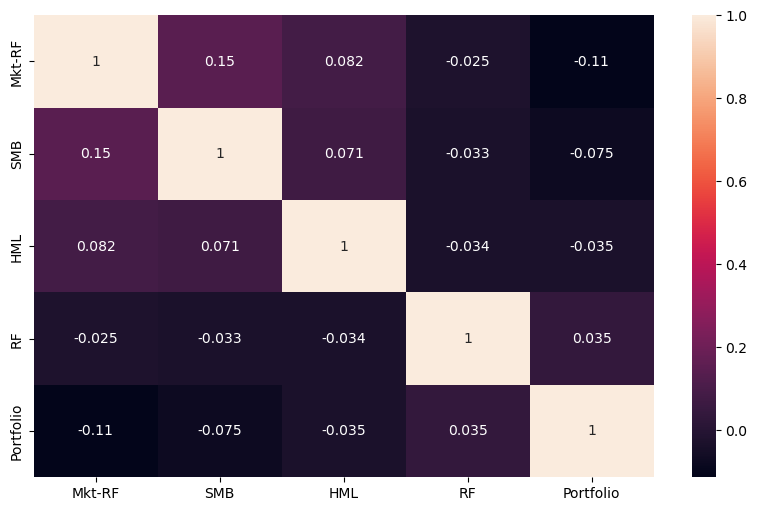

In [42]:
plt.subplots(figsize=(10,6))
sns.heatmap(ff_comp.corr(),annot=True)

We see that our strategy has very low correlation to any of the factors. This makes sense as the trading strategy is market neutral by entering positions when volatility is expected to be high. A market neutral element is also present in the delta-hedged component with options. 

***
# 5 Future Work

Other avenues to explore moving forward with this strategy include foreign currency, specifically looking at Japanese Yen (JPY), as there is research which shows the Yen is a safe haven for currency during times of market volatility. There is potential to have JPY included as another asset in this strategy, though this also introduces additional risk with the foreign exchange rate potentially moving against you.

***
# 6 Works Cited

[Ahoniemi, Katja. Modeling and forecasting implied volatility. Helsinki School of Economics, 2009.](https://core.ac.uk/download/pdf/14912922.pdf)

[Jubinski, Daniel & Lipton, Amy. (2013). VIX, Gold, Silver, and Oil: How do Commodities React to Financial Market Volatility? Journal of Accounting and Finance. 13. 70.](http://www.na-businesspress.com/jaf/jubinskid_web13_1_.pdf)

<table>
  <tr>
    <th>Asset</th>
    <th>Fee</th>
    <th>Source</th>
  </tr>
  <tr>
    <td>Short Selling SPY ETF</td>
    <td>0.3%</td>
    <td><a href='https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3862603'>Supply Constraints and Limits to Arbitrage in the ETF Loan Market</a></td>
  </tr>
  <tr>
    <td>TLT Bond ETF</td>
    <td>0.15% Management Fee</td>
    <td><a href='https://www.ishares.com/us/products/239454/ishares-20-year-treasury-bond-etf'>iShares 20+ Year Treasury Bond ETF</a></td>
  </tr>
  <tr>
    <td>SPY Options</td>
    <td>$0.65 per contract</td>
    <td><a href='https://www.schwab.com/pricing'>Charles Schwab Online Trade Fees</a></td>
  </tr>
  <tr>
    <td>SI and CL Futures Contracts</td>
    <td>$2.25 per contract</td>
    <td><a href='https://www.schwab.com/pricing'>Charles Schwab Online Trade Fees</a></td>
  </tr>
</table>